In [7]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

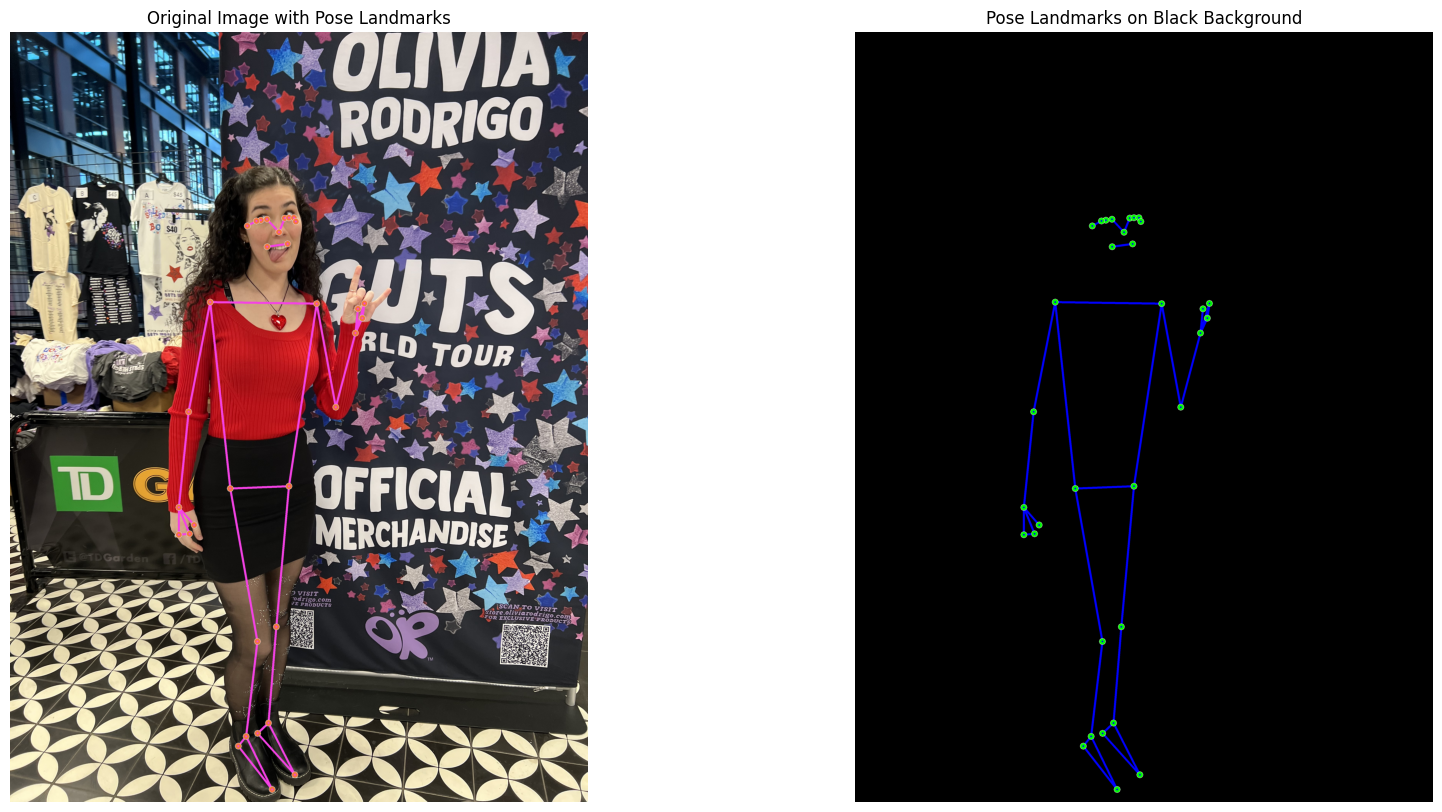

In [8]:
# Initialize MediaPipe Pose.
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
                    model_complexity=2,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)

# Load an image.
image_path = 'data/RODRIGO.jpg'
image = cv2.imread(image_path)

# Convert the BGR image to RGB.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image.
results = pose.process(image_rgb)

# Copy the image so we can draw on it.
image_output = image_rgb.copy()

# Draw pose landmarks on the image.
mp.solutions.drawing_utils.draw_landmarks(
    image_output, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=10, circle_radius=10),
    connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=10, circle_radius=10))

# Create a blank image (black background) for drawing.
image_black_bg = np.zeros_like(image_rgb)

# Draw pose landmarks on the black background image.
mp.solutions.drawing_utils.draw_landmarks(
    image_black_bg, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0,255,0), thickness=10, circle_radius=10),
    connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(color=(0,0,255), thickness=10, circle_radius=10))

# Plotting the images side by side.
fig, ax = plt.subplots(1, 2, figsize=(20,10))  # 1 row, 2 columns

# Display original image with landmarks.
ax[0].imshow(image_output)
ax[0].set_title('Original Image with Pose Landmarks')
ax[0].axis("off")

# Display landmarks on black background.
ax[1].imshow(image_black_bg)
ax[1].set_title('Pose Landmarks on Black Background')
ax[1].axis("off")

plt.show()
